In [25]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


#https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb

In [26]:
def identity_block(X,f,filters,stage,block):
    #defing name basis
    conv_name_base = 'res'+str(stage)+block+'_branch' #name of conv layer
    bn_name_base = 'bn'+str(stage)+block+'_branch'   #name of BatchNormalization
    
    #Retrieve Filters
    F1, F2, F3 = filters
    #Save the input value. will need this later to add back to main path
    X_shortcut = X
    
    #first component of main path
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid',name=conv_name_base+'2a',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name= bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    #second component of main path(3lines)
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same',name=conv_name_base+'2b',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name= bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    #third component of main path(2lines)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid',name=conv_name_base+'2c',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name= bn_name_base+'2c')(X)
    
    #final step : Add shortcut value to main path and pass ot through the relu
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X
    
    

In [27]:
def convolutional_block(X,f,filters,stage,block,s=2):
    #defing name basis
    conv_name_base = 'res'+str(stage)+block+'_branch' #name of conv layer
    bn_name_base = 'bn'+str(stage)+block+'_branch'   #name of BatchNormalization
    
    #Retrieve Filters
    F1, F2, F3 = filters
    #Save the input value. will need this later to add back to main path
    X_shortcut = X
    
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    
    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    #shortcut path(2lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X
    

In [41]:
def ResNet50(input_shape=(64,64,3),classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    #Zero-padding
    X = ZeroPadding2D((3,3))(X_input)
    
    #stage1
    X = Conv2D(64,(7,7),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


In [42]:

model = ResNet50(input_shape = (64, 64, 3), classes = 2)

In [43]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 70, 70, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

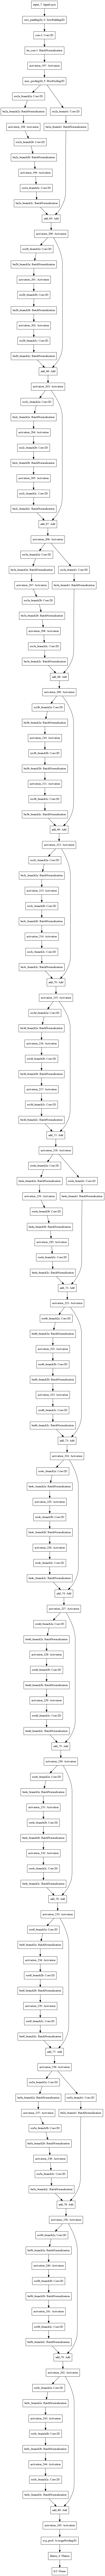

In [44]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(model, to_file='resnet.png')

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator(rescale=1./225,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

model.fit_generator(training_set,samples_per_epoch = 8000,nb_epoch = 1,validation_data = test_set,nb_val_samples = 2000)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/home/marzan/work_env/local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/marzan/work_env/local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_steps=2000, steps_per_epoch=250, validation_data=<keras.pre..., epochs=1)`


Epoch 1/1


In [ ]:
# serialize model to JSON
from keras.models import model_from_json
model_json = model.to_json()
with open("model_alexnet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_alexnet_weights.h5")
print("Saved model to disk")

In [ ]:
from keras.models import model_from_json
# Model reconstruction from JSON file
with open('model_alexnet.json', 'r') as f:
    model_after = model_from_json(f.read())

# Load weights into the new model
model_after.load_weights('model_alexnet_weights.h5')

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
img = cv2.imread("/media/marzan/mini storage/CNN/cat.jpg")

In [ ]:
reshape = cv2.resize(img,(64,64))
dimention_currection = np.reshape(reshape,[1,64,64,3])

In [ ]:
predict = model_after.predict(dimention_currection)
predict